<a href="https://colab.research.google.com/github/twyeh/highenergy/blob/main/c7_c7p_constraints_1608_02556.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install flavio

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.5/290.5 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.8/594.8 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.1 MB/s eta 0:00:00
  Created wheel for parton: filename=parton-0.2.2-py3-none-any.whl size=14000 sha256=6adf6d810cb808c1da7e45c27179103c591ce98f02524832d7550f87f083ee07
  Stored in directory: /root/.cache/pip/wheels/4f/5f/ba/4a4c454a28005125067382ffc0c3e967429b658917d062d75e
  Created wheel for pylha: filename=pylha-0.4-py3-none-any.whl size=58269 sha256=ffd8a6e9114a3bc97021e57f063ae2b211f19ad30133b09637b7e3076c5694d9
  Stored in directory: /root/.cache/pip/wheels/e5/fa/51/6cb033ac4cb2857410fa6e15c87a4501df116007d79c91b473
Successfully b

In [ ]:
!apt-get update
!apt-get install texlive-latex-extra texlive-fonts-recommended dvipng cm-super

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,688 kB]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [3,099 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,824 kB]
Get:14

# Constraints on $C_7$ and $C_7'$

This notebook generates the Wilson coefficient plots of the paper [arXiv:1608.02556](https://arxiv.org/abs/1608.02556) by Ayan Paul and David M. Straub. It uses [flavio](https://flav-io.github.io/) v0.20.

## Preliminaries

Loading packages

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import flavio
import flavio.plots
import flavio.statistics
import matplotlib.pyplot as plt
from collections import OrderedDict

In [ ]:
"""A fit is a collection of observables and parameters that can be used to
perform statistical analyses within a particular statistical framework.

Fits are instances of descendants of the `Fit` class (which is not meant
to be used directly)

Note that this module has been deprecated as of flavio v1.6.0. Please
use the `flavio.statistics.likelihood` module instead."""

import warnings
warnings.warn("The `flavio.statistics.fits` module has been deprecated"
              " as of flavio v1.6.0. Please use the `flavio.statistics.likelihood`"
              " module instead.",
              DeprecationWarning, stacklevel=2)


import flavio
import numpy as np
from flavio.statistics.probability import NormalDistribution, MultivariateNormalDistribution
from flavio.math.optimize import minimize_robust
from collections import Counter, OrderedDict
import warnings
import inspect
from multiprocessing import Pool
import scipy.optimize
import pickle
from functools import partial
import yaml


class Fit(flavio.NamedInstanceClass):
    """Base class for fits. Not meant to be used directly."""

    def __init__(self,
                 name,
                 par_obj=flavio.default_parameters,
                 fit_parameters=None,
                 nuisance_parameters=None,
                 observables=None,
                 fit_wc_names=None,
                 fit_wc_function=None,
                 fit_wc_priors=None,
                 input_scale=160.,
                 exclude_measurements=None,
                 include_measurements=None,
                 fit_wc_eft='WET',
                 fit_wc_basis='flavio',
                ):
        if fit_parameters is None:
            self.fit_parameters = []
        else:
            self.fit_parameters = fit_parameters
        if nuisance_parameters is None:
            self.nuisance_parameters = []
        elif nuisance_parameters == 'all':
            self.nuisance_parameters = par_obj.all_parameters
        else:
            self.nuisance_parameters = nuisance_parameters
        if observables is None:
            raise ValueError("'observables' is empty: you must specify at least one fit observable")
        if fit_wc_names is not None:
            warnings.warn("The 'fit_wc_names' argument is no longer necessary "
            "as of flavio v0.19 and might be removed in the future.",
            FutureWarning)
        # some checks to make sure the input is sane
        for p in self.nuisance_parameters:
            # check that nuisance parameters are constrained
            assert p in par_obj._parameters.keys(), "Parameter " + p + " not found in Constraints"
        for obs in observables:
            # check that observables exist
            try:
                if isinstance(obs, tuple):
                    flavio.classes.Observable[obs[0]]
                elif isinstance(obs, dict):
                    flavio.classes.Observable[obs['name']]
                elif isinstance(obs, str):
                    flavio.classes.Observable[obs]
                else:
                    ValueError("Unexpected form of observable: {}".format(obs))
            except:
                raise ValueError("Observable " + str(obs) + " not found!")
        _obs_measured = set()
        if exclude_measurements and include_measurements:
            raise ValueError("The options exclude_measurements and include_measurements must not be specified simultaneously")
        # check that no parameter appears as fit *and* nuisance parameter
        intersect = set(self.fit_parameters).intersection(self.nuisance_parameters)
        assert intersect == set(), "Parameters appearing as fit_parameters and nuisance_parameters: " + str(intersect)
        # check that the Wilson coefficient function works
        if fit_wc_function is not None: # if list of WC names not empty
            try:
                self.fit_wc_names = tuple(inspect.signature(fit_wc_function).parameters.keys())
                fit_wc_function(**{fit_wc_name: 1e-6 for fit_wc_name in self.fit_wc_names})
            except:
                raise ValueError("Error in calling the Wilson coefficient function")
        else:
            self.fit_wc_names = tuple()
        # now that everything seems fine, we can call the init of the parent class
        super().__init__(name)
        self.par_obj = par_obj
        self.parameters_central = self.par_obj.get_central_all()
        self.exclude_measurements = exclude_measurements
        self.include_measurements = include_measurements
        self.fit_wc_function = fit_wc_function
        self.fit_wc_priors = fit_wc_priors
        self.observables = observables
        self.input_scale = input_scale
        self._warn_meas_corr

        # check that observables are constrained
        for m_name in self.get_measurements:
            m_obj = flavio.Measurement[m_name]
            _obs_measured.update(m_obj.all_parameters)
        missing_obs = set(observables) - set(_obs_measured).intersection(set(observables))
        assert missing_obs == set(), "No measurement found for the observables: " + str(missing_obs)

        self.dimension = len(self.fit_parameters) + len(self.nuisance_parameters) + len(self.fit_wc_names)
        self.eft = fit_wc_eft
        self.basis = fit_wc_basis

    @property
    def get_central_fit_parameters(self):
        """Return a numpy array with the central values of all fit parameters."""
        return np.asarray([self.parameters_central[p] for p in self.fit_parameters])

    @property
    def get_random_fit_parameters(self):
        """Return a numpy array with random values for all fit parameters."""
        all_random = self.par_obj.get_random_all()
        return np.asarray([all_random[p] for p in self.fit_parameters])

    @property
    def get_random_wilson_coeffs(self):
        """Return a numpy array with random values for all Wilson coefficients."""
        if self.fit_wc_priors is None:
            return None
        all_random = self.fit_wc_priors.get_random_all()
        return np.asarray([all_random[p] for p in self.fit_wc_names])

    @property
    def get_central_nuisance_parameters(self):
        """Return a numpy array with the central values of all nuisance parameters."""
        return np.asarray([self.parameters_central[p] for p in self.nuisance_parameters])

    @property
    def get_random_nuisance_parameters(self):
        """Return a numpy array with random values for all nuisance parameters."""
        all_random = self.par_obj.get_random_all()
        return np.asarray([all_random[p] for p in self.nuisance_parameters])

    @property
    def get_measurements(self):
        """Return a list of all the measurements currently defined that
        constrain any of the fit observables."""
        all_measurements = []
        for m_name, m_obj in flavio.classes.Measurement.instances.items():
            if m_name.split(' ')[0] == 'Pseudo-measurement':
                # skip pseudo measurements generated by FastFit instances
                continue
            if set(m_obj.all_parameters).isdisjoint(self.observables):
                # if set of all observables constrained by measurement is disjoint
                # with fit observables, do nothing
                continue
            else:
                # else, add measurement name to output list
                all_measurements.append(m_name)
        if self.exclude_measurements is None and self.include_measurements is None:
            return all_measurements
        elif self.exclude_measurements is not None:
            return list(set(all_measurements) - set(self.exclude_measurements))
        elif self.include_measurements is not None:
            return list(set(all_measurements) & set(self.include_measurements))

    @property
    def _warn_meas_corr(self):
        """Warn the user if the fit contains multiple correlated measurements of
        an observable that is not included in the fit parameters, as this will
        lead to inconsistent results."""
        corr_with = {}
        # iterate over all measurements constraining at least one fit obs.
        for name in self.get_measurements:
            m = flavio.classes.Measurement[name]
            # iterate over all fit obs. constrained by this measurement
            for obs in set(self.observables) & set(m.all_parameters):
                # the constraint on this fit obs.
                constraint = m._parameters[obs][1]
                # find all the other obs. constrained by this constraint
                for c, p in m._constraints:
                    if c == constraint:
                        par = p
                        break
                for p in par:
                    # if the other obs. are not fit obs., append them to the list
                    if p not in self.observables:
                        if p not in corr_with:
                            corr_with[p] = [obs]
                        else:
                            corr_with[p].append(obs)
        # replace list by a Counter
        corr_with = {k: Counter(v) for k, v in corr_with.items() if v}
        # warn for all counts > 1
        for obs1, counter in corr_with.items():
            for obs2, count in counter.items():
                if count > 1:
                    warnings.warn(("{} of the measurements in the fit '{}' "
                                   "constrain both '{}' and '{}', but only the "
                                   "latter is included among the fit "
                                   "observables. This can lead to inconsistent "
                                   "results as the former is profiled over."
                                   ).format(count, self.name, obs1, obs2))
        return corr_with


    def array_to_dict(self, x):
        """Convert a 1D numpy array of floats to a dictionary of fit parameters,
        nuisance parameters, and Wilson coefficients."""
        d = {}
        n_fit_p = len(self.fit_parameters)
        n_nui_p = len(self.nuisance_parameters)
        n_wc = len(self.fit_wc_names)
        d['fit_parameters'] = { p: x[i] for i, p in enumerate(self.fit_parameters) }
        d['nuisance_parameters'] = { p: x[i + n_fit_p] for i, p in enumerate(self.nuisance_parameters) }
        d['fit_wc'] = { p: x[i + n_fit_p + n_nui_p] for i, p in enumerate(self.fit_wc_names) }
        return d

    def dict_to_array(self, d):
        """Convert a dictionary of fit parameters,
        nuisance parameters, and Wilson coefficients to a 1D numpy array of
        floats."""
        n_fit_p = len(self.fit_parameters)
        n_nui_p = len(self.nuisance_parameters)
        n_wc = len(self.fit_wc_names)
        arr = np.zeros(n_fit_p + n_nui_p + n_wc)
        arr[:n_fit_p] = [d['fit_parameters'][p] for p in self.fit_parameters]
        arr[n_fit_p:n_fit_p+n_nui_p] = [d['nuisance_parameters'][p] for p in self.nuisance_parameters]
        arr[n_fit_p+n_nui_p:]   = [d['fit_wc'][c] for c in self.fit_wc_names]
        return arr

    @property
    def get_random(self):
        """Get an array with random values for all the fit and nuisance
        parameters and Wilson coefficients."""
        return self._get_random()

    def _get_random(self, par=True, nuisance=True, wc=True):
        """Get an array with random values for all the fit and nuisance
        parameters and Wilson coefficients.

        If par is False, fit parameters are set to their central values.
        If nuisance is False, nuisance parameters are set to their central values.
        """
        arr = np.zeros(self.dimension)
        n_fit_p = len(self.fit_parameters)
        n_nui_p = len(self.nuisance_parameters)
        if par:
            arr[:n_fit_p] = self.get_random_fit_parameters
        else:
            arr[:n_fit_p] = self.get_central_fit_parameters
        if nuisance:
            arr[n_fit_p:n_fit_p+n_nui_p] = self.get_random_nuisance_parameters
        else:
            arr[n_fit_p:n_fit_p+n_nui_p] = self.get_central_nuisance_parameters
        if wc:
            arr[n_fit_p+n_nui_p:] = self.get_random_wilson_coeffs
        return arr

    @property
    def get_random_wilson_coeffs_start(self):
        """Return a numpy array with random values for all Wilson coefficients
        sampling the start_wc_priors distribution."""
        if self.fit_wc_function is None:
            # no Wilson coefficients present
            return None
        elif self.start_wc_priors is None:
            if self.fit_wc_priors is None:
                raise ValueError("Starting values can only be generated if"
                        " either fit_wc_priors or start_wc_priors is defined")
            else:
                return self.get_random_wilson_coeffs
        all_random = self.start_wc_priors.get_random_all()
        return np.asarray([all_random[p] for p in self.fit_wc_names])

    @property
    def get_random_start(self):
        """Get an array with random values for all the fit and nuisance
        parameters with Wilson coefficients set to their SM values"""
        arr = np.zeros(self.dimension)
        n_fit_p = len(self.fit_parameters)
        n_nui_p = len(self.nuisance_parameters)
        arr[:n_fit_p] = self.get_random_fit_parameters
        arr[n_fit_p:n_fit_p+n_nui_p] = self.get_random_nuisance_parameters
        arr[n_fit_p+n_nui_p:] = self.get_random_wilson_coeffs_start
        return arr

    def get_par_dict(self, x, par=True, nuisance=True):
        """Get a dictionary of fit and nuisance parameters from an input array

        If par is False, fit parameters are set to their central values.
        If nuisance is False, nuisance parameters are set to their central values.
        """
        d = self.array_to_dict(x)
        par_dict = self.parameters_central.copy()
        if par:
            par_dict.update(d['fit_parameters'])
        if nuisance:
            par_dict.update(d['nuisance_parameters'])
        return par_dict

    def get_wc_obj(self, x):
        wc_obj = flavio.WilsonCoefficients()
        # if there are no WCs to be fitted, return the SM WCs
        if not self.fit_wc_names:
            return wc_obj
        d = self.array_to_dict(x)
        wc_obj.set_initial(self.fit_wc_function(**d['fit_wc']), self.input_scale,
                           eft=self.eft, basis=self.basis)
        return wc_obj

    def log_prior_parameters(self, x):
        """Return the prior probability for all fit and nuisance parameters
        given an input array"""
        par_dict = self.get_par_dict(x)
        exclude_parameters = list(set(par_dict.keys())-set(self.fit_parameters)-set(self.nuisance_parameters))
        prob_dict = self.par_obj.get_logprobability_all(par_dict, exclude_parameters=exclude_parameters)
        return sum([p for obj, p in prob_dict.items()])

    def log_prior_wilson_coeffs(self, x):
        """Return the prior probability for all Wilson coefficients
        given an input array"""
        if self.fit_wc_priors is None:
            return 0
        wc_dict = self.array_to_dict(x)['fit_wc']
        prob_dict = self.fit_wc_priors.get_logprobability_all(wc_dict)
        return sum([p for obj, p in prob_dict.items()])

    def get_predictions(self, x, par=True, nuisance=True, wc=True):
        """Get a dictionary with predictions for all observables given an input
        array.

        If par is False, fit parameters are set to their central values.
        If nuisance is False, nuisance parameters are set to their central values.
        If wc is False, Wilson coefficients are set to their SM values.
        """
        par_dict = self.get_par_dict(x, par=par, nuisance=nuisance)
        if wc:
            wc_obj = self.get_wc_obj(x)
        else:
            wc_obj = flavio.physics.eft._wc_sm
        all_predictions = {}
        for observable in self.observables:
            if isinstance(observable, tuple):
                obs_name = observable[0]
                _inst = flavio.classes.Observable[obs_name]
                all_predictions[observable] = _inst.prediction_par(par_dict, wc_obj, *observable[1:])
            else:
                _inst = flavio.classes.Observable[observable]
                all_predictions[observable] = _inst.prediction_par(par_dict, wc_obj)
        return all_predictions

    def get_predictions_array(self, x, **kwargs):
        pred = self.get_predictions(x, **kwargs)
        return np.array([pred[obs] for obs in self.observables])

    def log_prior_parameters(self, x):
        """Return the prior probability (or frequentist likelihood) for all
        fit and (!) nuisance parameters given an input array"""
        par_dict = self.get_par_dict(x)
        exclude_parameters = list(set(par_dict.keys())-set(self.fit_parameters)-set(self.nuisance_parameters))
        prob_dict = self.par_obj.get_logprobability_all(par_dict, exclude_parameters=exclude_parameters)
        return sum([p for obj, p in prob_dict.items()])

    def log_prior_nuisance_parameters(self, x):
        """Return the prior probability (or frequentist likelihood) for all
        nuisance parameters given an input array"""
        par_dict = self.get_par_dict(x)
        exclude_parameters = list(set(par_dict.keys())-set(self.nuisance_parameters))
        prob_dict = self.par_obj.get_logprobability_all(par_dict, exclude_parameters=exclude_parameters)
        return sum([p for obj, p in prob_dict.items()])

    def log_likelihood_exp(self, x):
        """Return the logarithm of the likelihood function (not including the
        prior)"""
        predictions = self.get_predictions(x)
        ll = 0.
        for measurement in self.get_measurements:
            m_obj = flavio.Measurement[measurement]
            m_obs = m_obj.all_parameters
            exclude_observables = set(m_obs) - set(self.observables)
            prob_dict = m_obj.get_logprobability_all(predictions, exclude_parameters=exclude_observables)
            ll += sum(prob_dict.values())
        return ll


class BayesianFit(Fit):
    r"""Bayesian fit class. Instances of this class can then be fed to samplers.

    Parameters
    ----------

    - `name`: a descriptive string name
    - `par_obj`: optional; an instance of `ParameterConstraints`.
      Defaults to `flavio.default_parameters`
    - `fit_parameters`: a list of string names of parameters of interest. The existing
      constraints on the parameter will be taken as prior.
    - `nuisance_parameters`: a list of string names of nuisance parameters. The existing
      constraints on the parameter will be taken as prior. Alternatively, it
      can also be set to 'all', in which case all the parameters constrainted
      by `par_obj` will be treated as nuisance parameters. (Note that this makes
      sense for `FastFit`, but not for a MCMC since the number of nuisance
      parameters will be huge.)
    - `observables`: a list of observable names to be included in the fit
    - `exclude_measurements`: optional; a list of measurement names *not* to be included in
    the fit. By default, all existing measurements are included.
    - `include_measurements`: optional; a list of measurement names to be included in
    the fit. By default, all existing measurements are included.
    - `fit_wc_names`: optional; a list of string names of arguments of the Wilson
      coefficient function below
    - `fit_wc_function`: optional; a function that
      returns a dictionary that can be fed to the `set_initial`
      method of the Wilson coefficient class. Example: fit the real and imaginary
      parts of $C_{10}$ in $b\to s\mu^+\mu^-$.
    ```
    def fit_wc_function(Re_C10, Im_C10):
        return {'C10_bsmmumu': Re_C10 + 1j*Im_C10}
    ```
    - `input_scale`: input scale for the Wilson coeffficients. Defaults to 160.
    - `fit_wc_priors`: optional; an instance of WilsonCoefficientPriors
      containing prior constraints on the Wilson coefficients
    - `start_wc_priors`: optional; an instance of WilsonCoefficientPriors
      that will not be used during a scan, but only for finding starting values
      for Wilson coefficients in MCMC analyses. This can be useful if no
      actual priors are used or if they are too loose to provide good starting
      points.
    """

    def __init__(self, *args, start_wc_priors=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.start_wc_priors = start_wc_priors

        for p in self.fit_parameters:
            # check that fit parameters are constrained
            assert p in self.par_obj._parameters.keys(), "Parameter " + p + " not found in Constraints"

    @property
    def get_random(self):
        """Get an array with random values for all the fit and nuisance
        parameters"""
        arr = np.zeros(self.dimension)
        n_fit_p = len(self.fit_parameters)
        n_nui_p = len(self.nuisance_parameters)
        arr[:n_fit_p] = self.get_random_fit_parameters
        arr[n_fit_p:n_fit_p+n_nui_p] = self.get_random_nuisance_parameters
        arr[n_fit_p+n_nui_p:] = self.get_random_wilson_coeffs
        return arr

    def log_target(self, x):
        """Return the logarithm of the likelihood times prior probability"""
        return self.log_likelihood_exp(x) + self.log_prior_parameters(x) + self.log_prior_wilson_coeffs(x)


class FastFit(Fit):
    r"""A fit class that is meant for producing fast likelihood contour plots.

    Calling the method `make_measurement`, a pseudo-measurement is generated
    that combines the actual experimental measurements with the theoretical
    uncertainties stemming from the nuisance parameters. This is done by
    generating random samples of the nuisance parameters and evaluating all
    observables within the Standard Model many times (100 by default).
    Then, the covariance of all predictions is extracted. Similarly, a covariance
    matrix for all experimental measurements is determined. Both covariance
    matrices are added and the resulting multivariate Gaussian treated as a
    single measurement.

    This approach has the advantage that two-dimensional plots of the likelihood
    can be produced without the need for sampling or profiling the other
    dimensions. However, several strong assumptions go into this method, most
    importantly,

    - all uncertainties - experimental and theoretical - are treated as Gaussian
    - the theoretical uncertainties in the presence of new physics are assumed
      to be equal to the ones in the SM
    """

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.measurements = None
        self._sm_covariance = None
        self._exp_central_covariance = None
        self._get_predictions_array_sm = partial(self.get_predictions_array,
                                                 par=False, nuisance=True,
                                                 wc=False)


    # a method to get the mean and covariance of all measurements of all
    # observables of interest
    def _get_central_covariance_experiment(self, N=5000):
        means = []
        covariances = []
        for measurement in self.get_measurements:
            m_obj = flavio.Measurement[measurement]
            # obs. included in the fit and constrained by this measurement
            our_obs = set(m_obj.all_parameters).intersection(self.observables)
            # construct a dict. containing a vector of N random values for
            # each of these observables
            random_dict = {}
            for obs in our_obs:
                random_dict[obs] = np.zeros(N)
            for i in range(N):
                m_random = m_obj.get_random_all()
                for obs in our_obs:
                    random_dict[obs][i] = m_random[obs]
            # mean = np.zeros(len(self.observables))
            random_arr = np.zeros((len(self.observables), N))
            for i, obs in enumerate(self.observables):
                #     n = len(random_dict[obs])
                if obs in our_obs:
                    random_arr[i] = random_dict[obs]
            mean = np.mean(random_arr, axis=1)
            covariance = np.cov(random_arr)
            for i, obs in enumerate(self.observables):
                if obs not in our_obs:
                    covariance[:,i] = 0
                    covariance[i, :] = 0
                    covariance[i, i] = np.inf
            means.append(mean)
            covariances.append(covariance)
        # if there is only a single measuement
        if len(means) == 1:
            if len(means[0]) == 1:
                # if there is only a single observable
                return means[0][0], covariances[0]
            else:
                return means[0], covariances[0]
        # if there are severeal measurements, perform a weighted average
        else:
            # covariances: [Sigma_1, Sigma_2, ...]
            # means: [x_1, x_2, ...]
            # weights_ [W_1, W_2, ...] where W_i = (Sigma_i)^(-1)
            # weighted covariance is  (W_1 + W_2 + ...)^(-1) = Sigma
            # weigted mean is  Sigma.(W_1.x_1 + W_2.x_2 + ...) = x
            if len(self.observables) == 1:
                weights = np.array([1/c for c in covariances])
                weighted_covariance = 1/np.sum(weights, axis=0)
                weighted_mean = weighted_covariance * np.sum(
                                [np.dot(weights[i], means[i]) for i in range(len(means))])
            else:
                weights = [np.linalg.inv(c) for c in covariances]
                weighted_covariance = np.linalg.inv(np.sum(weights, axis=0))
                weighted_mean = np.dot(weighted_covariance, np.sum(
                                [np.dot(weights[i], means[i]) for i in range(len(means))],
                                axis=0))
            return weighted_mean, weighted_covariance

    def get_exp_central_covariance(self, N=5000, force=True):
        """Return the experimental central values and the covriance matrix of
        all observables.

        Parameters:

        - `N`: number of random computations (computing time is proportional
          to it; more means less random fluctuations.)
        - `force`: optional; if True (default), will recompute covariance even
          if it already has been computed.
        """
        if self._exp_central_covariance is None or force:
            self._exp_central_covariance = self._get_central_covariance_experiment(N=N)
        elif N != 5000:
            warnings.warn("Argument N={} ignored ".format(N) + \
                          "as experimental covariance has already been " + \
                          "computed. Recompute with get_exp_central_covariance.")
        return self._exp_central_covariance

    def save_exp_central_covariance(self, filename):
        """Save the experimental central values and the covriance to a pickle
        file.

        The central values and the covariance must have been computed before
        using `get_exp_central_covariance`."""
        if self._exp_central_covariance is None:
            raise ValueError("Call get_exp_central_covariance or make_measurement first.")
        with open(filename, 'wb') as f:
            data = dict(central=self._exp_central_covariance[0],
                        covariance=self._exp_central_covariance[1],
                        observables=self.observables)
            pickle.dump(data, f)

    def load_exp_central_covariance(self, filename):
        """Load the experimental central values and the covriance from a pickle
        file."""
        with open(filename, 'rb') as f:
            data = pickle.load(f)
        self.load_exp_central_covariance_dict(d=data)

    def load_exp_central_covariance_dict(self, d):
        """Load the the experimental central values and the covriancee from a
        dictionary.

        It must have the form
        {'observables': [...], 'central': [...], 'covariance': [[...]]}
        where 'central' is a vector of central values and 'covariance' is a
        covariance matrix, both in the basis of observables given by
        'observables' which must at least contain all the observables
        involved in the fit. Additional observables will be ignored; the
        ordering is arbitrary."""
        obs = d['observables']
        try:
            permutation = [obs.index(o) for o in self.observables]
        except ValueError:
            raise ValueError("Covariance matrix does not contain all necessary entries")
        assert len(permutation) == len(self.observables), \
            "Covariance matrix does not contain all necessary entries"
        if len(permutation) == 1:
            self._exp_central_covariance = (
                d['central'],
                d['covariance']
            )
        else:
            self._exp_central_covariance = (
                d['central'][permutation],
                d['covariance'][permutation][:,permutation],
            )

    # a method to get the covariance of the SM prediction of all observables
    # of interest
    def _get_random_nuisance(self, *args):
        return self._get_random(par=False, nuisance=True, wc=False)

    def _get_covariance_sm(self, N=100, threads=1):
        if threads == 1:
            X_map = map(self._get_random_nuisance, range(N))
            pred_map = map(self._get_predictions_array_sm, X_map)
        else:
            pool = Pool(threads)
            X_map = pool.map(self._get_random_nuisance, range(N))
            pred_map = pool.map(self._get_predictions_array_sm, X_map)
            pool.close()
            pool.join()
        pred_arr = np.empty((N, len(self.observables)))
        for i, pred_i in enumerate(pred_map):
            pred_arr[i] = pred_i
        return np.cov(pred_arr.T)

    def get_sm_covariance(self, N=100, threads=1, force=True):
        """Return the covriance matrix of the SM predictions of all observables
        under variation of all nuisance parameters.

        Parameters:

        - `N`: number of random computations (computing time is proportional
          to it; more means less random fluctuations.)
        - `threads`: optional; number of parallel threads. Defaults to 1 (no
          parallelization)
        - `force`: optional; if True (default), will recompute covariance even
          if it already has been computed.
        """
        if self._sm_covariance is None or force:
            self._sm_covariance = self._get_covariance_sm(N=N, threads=threads)
        elif N != 100:
            warnings.warn("Argument N={} ignored ".format(N) + \
                          "as SM covariance has already " + \
                          "been computed. Recompute with get_sm_covariance.")
        return self._sm_covariance

    def save_sm_covariance(self, filename):
        """Save the SM covariance to a pickle file.

        The covariance must have been computed before using
        `get_sm_covariance`."""
        if self._sm_covariance is None:
            raise ValueError("Call get_sm_covariance or make_measurement first.")
        with open(filename, 'wb') as f:
            data = dict(covariance=self._sm_covariance,
                        observables=self.observables)
            pickle.dump(data, f)

    def load_sm_covariance(self, filename):
        """Load the SM covariance from a pickle file."""
        with open(filename, 'rb') as f:
            data = pickle.load(f)
        self.load_sm_covariance_dict(d=data)

    def load_sm_covariance_dict(self, d):
        """Load the SM covariance from a dictionary.

        It must have the form {'observables': [...], 'covariance': [[...]]}
        where 'covariance' is a covariance matrix in the basis of observables
        given by 'observables' which must at least contain all the observables
        involved in the fit. Additional observables will be ignored; the
        ordering is arbitrary."""
        obs = d['observables']
        try:
            permutation = [obs.index(o) for o in self.observables]
        except ValueError:
            raise ValueError("Covariance matrix does not contain all necessary entries")
        assert len(permutation) == len(self.observables), \
            "Covariance matrix does not contain all necessary entries"
        if len(permutation) == 1:
            if d['covariance'].shape == ():
                self._sm_covariance = d['covariance']
            else:
                self._sm_covariance = d['covariance'][permutation][:,permutation][0,0]
        else:
            self._sm_covariance = d['covariance'][permutation][:,permutation]

    def make_measurement(self, N=100, Nexp=5000, threads=1, force=False, force_exp=False):
        """Initialize the fit by producing a pseudo-measurement containing both
        experimental uncertainties as well as theory uncertainties stemming
        from nuisance parameters.

        Optional parameters:

        - `N`: number of random computations for the SM covariance (computing
          time is proportional to it; more means less random fluctuations.)
        - `Nexp`: number of random computations for the experimental covariance.
          This is much less expensive than the theory covariance, so a large
          number can be afforded (default: 5000).
        - `threads`: number of parallel threads for the SM
          covariance computation. Defaults to 1 (no parallelization).
        - `force`: if True, will recompute SM covariance even if it
          already has been computed. Defaults to False.
        - `force_exp`: if True, will recompute experimental central values and
          covariance even if they have already been computed. Defaults to False.
        """
        central_exp, cov_exp = self.get_exp_central_covariance(Nexp, force=force_exp)
        cov_sm = self.get_sm_covariance(N, force=force, threads=threads)
        covariance = cov_exp + cov_sm
        # add the Pseudo-measurement
        m = flavio.classes.Measurement('Pseudo-measurement for FastFit instance: ' + self.name)
        if np.asarray(central_exp).ndim == 0 or len(central_exp) <= 1: # for a 1D (or 0D) array
            m.add_constraint(self.observables,
                    NormalDistribution(central_exp, np.sqrt(covariance)))
        else:
            m.add_constraint(self.observables,
                    MultivariateNormalDistribution(central_exp, covariance))

    def shortarray_to_dict(self, x):
        """Convert a 1D numpy array of floats to a dictionary of fit parameters
        and Wilson coefficients."""
        d = {}
        n_fit_p = len(self.fit_parameters)
        n_wc = len(self.fit_wc_names)
        d['fit_parameters'] = { p: x[i] for i, p in enumerate(self.fit_parameters) }
        d['fit_wc'] = { p: x[i + n_fit_p] for i, p in enumerate(self.fit_wc_names) }
        return d

    def dict_to_shortarray(self, d):
        """Convert a dictionary of fit parameters and Wilson coefficients to a
        1D numpy array of floats."""
        n_fit_p = len(self.fit_parameters)
        n_wc = len(self.fit_wc_names)
        arr = np.zeros(n_fit_p + n_nui_p + n_wc)
        arr[:n_fit_p] = [d['fit_parameters'][p] for p in self.fit_parameters]
        arr[n_fit_p:]   = [d['fit_wc'][c] for c in self.fit_wc_names]
        return arr

    def shortarray_to_array(self, x):
        """Convert an array of fit parameters and Wilson coefficients to an
        array of fit parameters, nuisance parameters, and Wilson coefficients
        (setting nuisance parameters to their central values)."""
        n_fit_p = len(self.fit_parameters)
        n_nui_p = len(self.nuisance_parameters)
        n_wc = len(self.fit_wc_names)
        arr = np.zeros(n_fit_p + n_nui_p + n_wc)
        arr[:n_fit_p] = x[:n_fit_p]
        arr[n_fit_p:n_fit_p+n_nui_p] = self.get_central_nuisance_parameters
        arr[n_fit_p+n_nui_p:] = x[n_fit_p:]
        return arr

    def log_likelihood(self, x):
        """Return the logarithm of the likelihood. Note that there is no prior
        probability for nuisance parameters, which have been integrated out.
        Priors for fit parameters are ignored."""
         # set nuisance parameters to their central values!
        predictions = self.get_predictions(self.shortarray_to_array(x), nuisance=False)
        m_obj = flavio.Measurement['Pseudo-measurement for FastFit instance: ' + self.name]
        m_obs = m_obj.all_parameters
        prob_dict = m_obj.get_logprobability_all(predictions)
        ll = sum(prob_dict.values())
        return ll

    def best_fit(self, **kwargs):
        r"""Compute the best fit point in the space of fit parameters and Wilson
        coefficients.

        Keyword arguments will be passed to `scipy.optimize.minimize_scalar` in
        the case of a single fit variable and to `flavio.math.optimize.minimize_robust`
        in the case of multiple fit variables.

        Returns a dictionary with the following keys:

        - 'x': position of the best fit point
        - 'log_likelihood': logarithm of the likelihood at the best fit point
        """
        n_fit_p = len(self.fit_parameters)
        n_wc = len(self.fit_wc_names)
        if n_fit_p + n_wc == 1:
            def f(x):
                return -self.log_likelihood([x])
            opt = scipy.optimize.minimize_scalar(f, **kwargs)
        else:
            def f(x):
                return -self.log_likelihood(x)
            if 'x0' not in kwargs:
                x0 = np.zeros(n_fit_p + n_wc)
                if n_fit_p > 1:
                    x0[:n_fit_p] = self.get_central_fit_parameters
                opt = minimize_robust(f, x0, **kwargs)
            else:
                opt = minimize_robust(f, **kwargs)
        if not opt.success:
            raise ValueError("Optimization failed.")
        else:
            return {'x': opt.x, 'log_likelihood': -opt.fun}


class FrequentistFit(Fit):
    r"""Frequentist fit class.


    Parameters
    ----------

    - `name`: a descriptive string name
    - `par_obj`: optional; an instance of `ParameterConstraints`.
      Defaults to `flavio.default_parameters`
    - `fit_parameters`: a list of string names of parameters of interest.
      Existing constraints on the parameter will be ignored.
    - `nuisance_parameters`: a list of string names of nuisance parameters. The existing
      constraints on the parameter will be interpreted as pseudo-measurement
      entering the likelihood.
    - `observables`: a list of observable names to be included in the fit
    - `exclude_measurements`: optional; a list of measurement names *not* to be included in
    the fit. By default, all existing measurements are included.
    - `include_measurements`: optional; a list of measurement names to be included in
    the fit. By default, all existing measurements are included.
    - `fit_wc_names`: optional; a list of string names of arguments of the Wilson
      coefficient function below
    - `fit_wc_function`: optional; a function that
      returns a dictionary that can be fed to the `set_initial`
      method of the Wilson coefficient class. Example: fit the real and imaginary
      parts of $C_{10}$ in $b\to s\mu^+\mu^-$.
    ```
    def fit_wc_function(Re_C10, Im_C10):
        return {'C10_bsmmumu': Re_C10 + 1j*Im_C10}
    ```
    - `input_scale`: input scale for the Wilson coeffficients. Defaults to 160.
    """

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def log_likelihood(self, x):
        """Return the logarithm of the likelihood function (including the
        lihelihood of nuisance parameters!)"""
        return self.log_likelihood_exp(x) + self.log_prior_nuisance_parameters(x)

Load the LCSR-only $B\to V$ form factors from [arXiv:1503.05534](https://arxiv.org/abs/1503.05534) (instead of the combined LCSR-LQCD fit used by default; see appendix A)

In [ ]:
flavio.physics.bdecays.formfactors.b_v.bsz_parameters.bsz_load_v2_lcsr(flavio.default_parameters)

Relevant observables

In [ ]:
observables = [
  'BR(B+->K*gamma)',
  'BR(B->Xsgamma)',
  'BR(B0->K*gamma)',
  'BR(Bs->phigamma)',
  'ADeltaGamma(Bs->phigamma)',
  'S_K*gamma',
  ('<ATIm>(B0->K*ee)', 0.002, 1.12),
  ('<P1>(B0->K*ee)', 0.002, 1.12),
]

## Setting up the fits

Defining the `FastFit` instances for a given Wilson coefficient scenario and observable set. See [the documentation](https://flav-io.github.io/docs/fits.html) for details.

In [ ]:
def wc_fct(C7Re, C7Im, C7pRe, C7pIm):
    return { 'C7_bs': C7Re + 1j * C7Im, 'C7p_bs': C7pRe + 1j * C7pIm }

In [ ]:
def fastfit_obs(name, obslist):
    return FastFit(
                name = name,
                nuisance_parameters = [p for p in flavio.default_parameters.all_parameters if p not in ['alpha_s', 'alpha_e', 'm_Z']],
                observables = obslist,
                fit_wc_function = wc_fct,
                input_scale = 4.8,
            )

In [ ]:
fits = OrderedDict()
fits['BR'] = ['BR(B+->K*gamma)', 'BR(B->Xsgamma)', 'BR(B0->K*gamma)', 'BR(Bs->phigamma)',]
fits['A'] = ['ADeltaGamma(Bs->phigamma)']
fits['P1'] = [('<P1>(B0->K*ee)', 0.002, 1.12)]
fits['S'] = ['S_K*gamma']
fits['ATIm'] = [('<ATIm>(B0->K*ee)', 0.002, 1.12)]

In [ ]:
labels = {
    'BR': 'branching ratios',
    'A': flavio.Observable.get_instance(fits['A'][0]).tex,
    'S': flavio.Observable.get_instance(fits['S'][0]).tex,
    'ATIm': flavio.Observable.get_instance(fits['ATIm'][0][0]).tex,
    'P1': flavio.Observable.get_instance(fits['P1'][0][0]).tex,
}

Generating the pseudo measurements for all the fits.

In [ ]:
%%time
obs_fastfits={}
for k, v in fits.items():
    obs_fastfits[k] = fastfit_obs('C7-C7p fit '+ k, v)
    obs_fastfits[k].make_measurement(N=200, threads=4)

CPU times: user 3.61 s, sys: 692 ms, total: 4.31 s
Wall time: 3min 53s


In [ ]:
%%time
global_fastfit = fastfit_obs('C7-C7p fit global', observables)
global_fastfit.make_measurement(N=200, threads=4)

CPU times: user 1.76 s, sys: 257 ms, total: 2.02 s
Wall time: 2min 55s


## Results

/usr/local/lib/python3.11/dist-packages/flavio/plots/plotfunctions.py:670: UserWarning: The smallest `z` value on the grid will be used as the minimum of the function to plot. This can lead to undesired results if the actual minimum is considerably different from the minimum on the grid. For better precision, the actual minimum should be provided in the `z_min` argument.
  warnings.warn("The smallest `z` value on the grid will be used as the "


CPU times: user 2.4 s, sys: 890 ms, total: 3.29 s
Wall time: 7min 10s


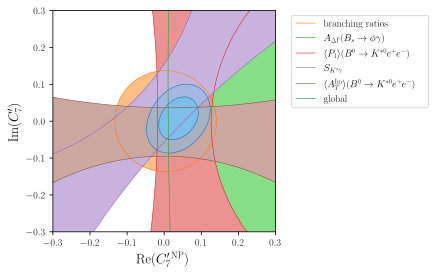

In [ ]:
%%time
fig=plt.figure(figsize=(4,4))
x_max=0.33
plt.xlim([-0.3,0.3])
plt.ylim([-0.3,0.3])
for i, f in enumerate(fits):
    def ll(x): # log likelihood for Re, Im C7'
        return obs_fastfits[f].log_likelihood([0, 0, x[0], x[1]])
    flavio.plots.likelihood_contour(ll,
                       -x_max, x_max, -x_max, x_max, n_sigma=1, col=i+1, label=labels[f],
                        interpolation_factor=3, threads=4)
def ll(x): # log likelihood for Re, Im C7'
    return global_fastfit.log_likelihood([0, 0, x[0], x[1]])
flavio.plots.likelihood_contour(ll,
                       -x_max, x_max, -x_max, x_max, n_sigma=(1, 2), col=0,
                       interpolation_factor=10, threads=4, label='global')

# labels, legend
plt.xlabel(r'$\text{Re}(C_7^{\prime\,\text{NP}})$')
plt.ylabel(r'$\text{Im}(C_7^\prime)$')
plt.legend(loc=2, bbox_to_anchor=(1.05, 1))

/usr/local/lib/python3.11/dist-packages/flavio/plots/plotfunctions.py:670: UserWarning: The smallest `z` value on the grid will be used as the minimum of the function to plot. This can lead to undesired results if the actual minimum is considerably different from the minimum on the grid. For better precision, the actual minimum should be provided in the `z_min` argument.
  warnings.warn("The smallest `z` value on the grid will be used as the "
/usr/local/lib/python3.11/dist-packages/flavio/math/integrate.py:5: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return scipy.integrate.qu

CPU times: user 3.45 s, sys: 918 ms, total: 4.37 s
Wall time: 12min 17s


Text(0, 0.5, '$\\text{Re}(C_7^{\\prime\\,\\text{NP}})$')

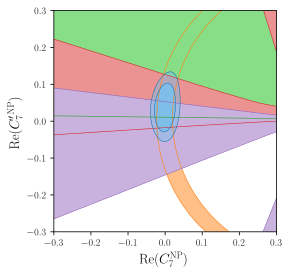

In [ ]:
%%time
fig2=plt.figure(figsize=(4,4))
x_max=0.36
plt.xlim([-0.3,0.3])
plt.ylim([-0.3,0.3])
for i, f in enumerate(fits):
    if f == 'ATIm':
        continue # no need to plot ATIm
    def ll(x): # log likelihood for Re C7, Re C7'
        return obs_fastfits[f].log_likelihood([x[0], 0, x[1], 0])
    flavio.plots.likelihood_contour(ll,
                       -x_max, x_max, -x_max, x_max, n_sigma=1, col=i+1, interpolation_factor=3, steps=30, threads=4)
def ll(x): # log likelihood for Re C7, Re C7'
    return global_fastfit.log_likelihood([x[0], 0, x[1], 0])
flavio.plots.likelihood_contour(ll,
                       -x_max, x_max, -x_max, x_max, n_sigma=(1,2),
                       col=0, interpolation_factor=10, threads=4)

# labels
plt.xlabel(r'$\text{Re}(C_7^\text{NP})$')
plt.ylabel(r'$\text{Re}(C_7^{\prime\,\text{NP}})$')